# Predicting Lineups with Count-Approximated Probabilities

This notebook is to wrangle football lineup and player availalibity data and find explore how to predict future lineups given player availabity.

# Step 1: Load and Transform Data

Load player data.

In [1]:
# Import
import os
os.chdir('/workspaces/codespaces-jupyter/')
from src.core.ETL import FPL_data
from src.core.predict import players_short_term_trends

# Load snapshot
snapshot = 'present'
FPL = FPL_data.pipeline(offline=True, raw_data_location=snapshot)
FPL.load_all()

# Load all player data
source_df = players_short_term_trends.get_player_match_data(FPL, ['22-23', '21-22'])

# Display example record
source_df.iloc[0]

Name                     Ramsdale Aaron Ramsdale (Arsenal, Goalkeeper)
Starts                                                               1
Mins                                                              90.0
On                                                                 0.0
Off                                                                0.0
Vs                                                                 CRY
GW                                                                 1.0
Date                                               2022-08-05 00:00:00
Home                                                             False
xA                                                                0.01
xG                                                                 0.0
Pen Goals                                                          0.0
season                                                           22-23
element                                                             15
id    

All is needed is 'Starts' and 'Available', plus identification data (player, team and date).

In [2]:
df = source_df[['element', 'team', 'kickoff_time', 'Starts', 'Available']]

Check data is correct.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41420 entries, 0 to 41419
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   element       41420 non-null  int64         
 1   team          41420 non-null  int64         
 2   kickoff_time  41420 non-null  datetime64[ns]
 3   Starts        41420 non-null  int64         
 4   Available     41420 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 1.9 MB


In [4]:
df.describe()

,element,team,Starts,Available
count,41420.000000,41420.000000,41420.000000,41420.000000
mean,362.963303,10.473394,0.327933,0.729382
std,216.397610,5.708885,0.469466,0.444284
min,1.000000,1.000000,0.000000,0.000000
25%,179.000000,6.000000,0.000000,0.000000
50%,346.500000,11.000000,0.000000,1.000000
75%,538.000000,15.000000,1.000000,1.000000
max,778.000000,20.000000,1.000000,1.000000


In [5]:
df.sample(10)

,element,team,kickoff_time,Starts,Available
26805,305,13,2022-12-31,1,1
1290,630,1,2023-05-20,0,0
13445,158,7,2023-04-22,0,1
33868,419,17,2021-11-05,1,1
16663,191,8,2022-01-22,1,1
37188,554,18,2023-02-26,0,0
11228,724,6,2023-01-15,0,0
16383,189,8,2022-09-03,1,1
2423,32,2,2023-04-08,0,1
34953,778,17,2023-04-21,0,0


Now that we have verified the data is as expected, we can do some analysis.

# Step 2: Data Exploration

### Thoughts About What 'Starts' and 'Available' Can Give Us

If we are attempting to predict which eleven players will start, we must consider how players are chosen. Generally speaking, managers have a preference for particular players and lineups. If all players were always available, you could simply use raw starting frequencies, as managers would not be forced to start players more often than previously due to unavailability. The goal of this project is to predict which players will start, given player availability.
Let's consider the simple case where there are two goalkeepers fighting for the goalkeeper position. Let's define our notation such that $A$ is the event that player $A$ is available, and event $A_*$ as player $A$ starts.

This means that instead of looking for $P(A)$, we are looking for $P(A_* | A, B)$. 

In this case, these equations are true:

$P(A_* | A, B) + P(B_* | A, B) = 1$,

$P(A_* | A, ¬B) = P(B_* | ¬A, B) = 1$,

$P(A_* | B_*) = P(B_* | A_*) = 0$.

Note that the following is always true:

$P(A_* | ¬A) = P(B_* | ¬B) = 0$.

If we add a third goalkeeper $C$, the equations get messier:

$P(A_* | A, B, C) = 1 - P(B_* | A, B, C) - P(C_* | A, B, C)$,

$P(A_* | A, B, ¬C) + P(B_* | A, B, ¬C) = P(A_* | A, ¬B, C) + P(C_* | A, ¬B, C) = P(B_* | ¬A, B, C) + P(C_* | ¬A, B, C) = 1$,

$P(A_* | A, ¬B, ¬C) = P(B_* | ¬A, B, ¬C) = P(C_* | ¬A, ¬B, C) = 1$,

$P(A_* | B_*) = P(A_* | C_*) = P(B_* | A_*) = P(B_* | C_*) = P(C_* | A_*) = P(C_* | B_*) = 0$.

Note that for case where we are given information that a player is available but does not start, the equations are written similarly to the case where that player is simply not available.

What if, instead we have a theoretical game where three players ($A$, $B$ and $C$) are competing for two spots? It is more complex still:

$P(A_* | A, B, C) + P(B_* | A, B, C) + P(C_* | A, B, C) = 2$,

$P(A_*, B_* | A, B, C) + P(A_*, C_* | A, B, C) + P(B_*, C_* | A, B, C) = 1$,

$P(A_*, B_* | A, B, ¬C) = P(A_*, C_* | A, ¬B, C) = P(B_*, C_* | ¬A, B, C) = 1$,

$P(A_* | A, B, C_*) + P(B_* | A, B, C_*) = P(A_* | A, B_*, C) + P(C_* | A, B_*, C) = P(B_* | A_*, B, C) + P(C_* | A_*, B, C) = 1$,

$P(A_* | B_*, C_*) = P(B_* | A_*, C_*) = P(C_* | A_*, B_*) = 0$.

In reality, teams have a maximum of 25 players in its Premier League squad to fill 11 positions. That is $25C11 = 4457400$ combinations (as opposed to the $3C2 = 3$ combinations we just had). For outfield positions, we can filter out goalkeepers: reducing combinations to $~22C10 = 646646$. Given that there are 38 games in a Premier League season, most combinations of full teams have never occurred before. Due to the randomness of player availability, novel lineups are likely to occur. Therefore, it seems reasonable to focus on pairwise comparisons of players, rather than considering the probabilities of larger groups of players. And this is closer to how people think: if a left-back gets injured, the reserve left-back is a logical replacement, even if that exact lineup has never occurred before.

Perhaps you wondered why I wrote out probabilities such as $P(A_* | B_*)$ when we will not be given player starting data before a game. The reason is because it is still useful for evaluating computer-generated teams. We can estimate the likelihood of a generated team by considering if the chosen group of players tend to play together by using these probabilities. We can use this information for a reward function for randomised or policy-driven team selections.


### A Quick Note on Player Positions

Player positions are largely an abstraction. In theory (and often in practice), any player can play anywhere. The only exception to this rule are goalkeepers, which is clearly defined in the rules of the game, with (almost) no interchanging between outfield players. Also, the positions of players is largely interpreted and not official, and sometimes managers can change formation completely and break any benefit of having dedicated positions for players.

### Visualising the Pairwise Comparisons

For each pair, I want to approximate $P(A_*|A, B)$, $P(A_*| A, B_*)$ and $P(A_*| A, ¬B)$.

First, I will use the data from one team in one season (I will consider optimal time windows later).

In [6]:
sample = df.loc[(df.kickoff_time > '2023-01-01')]

sample

,element,team,kickoff_time,Starts,Available
16,15,1,2023-01-03,1,1
17,15,1,2023-01-15,1,1
18,15,1,2023-01-22,1,1
19,15,1,2023-02-04,1,1
20,15,1,2023-02-11,1,1
...,...,...,...,...,...
41415,657,20,2023-04-29,0,0
41416,657,20,2023-05-06,0,1
41417,657,20,2023-05-13,0,1
41418,657,20,2023-05-20,0,1


In [7]:
def mesh_func(df):
    return df.merge(df, on=['kickoff_time', 'team'])

sample_mesh = mesh_func(sample)

sample_mesh

,element_x,team,kickoff_time,Starts_x,Available_x,element_y,Starts_y,Available_y
0,15,1,2023-01-03,1,1,15,1,1
1,15,1,2023-01-03,1,1,24,0,1
2,15,1,2023-01-03,1,1,655,0,1
3,15,1,2023-01-03,1,1,26,1,1
4,15,1,2023-01-03,1,1,16,1,1
...,...,...,...,...,...,...,...,...
568520,657,20,2023-05-28,0,1,608,0,0
568521,657,20,2023-05-28,0,1,481,1,1
568522,657,20,2023-05-28,0,1,476,1,1
568523,657,20,2023-05-28,0,1,625,0,1


Define a function for finding probabilities with given conditions.

In [8]:
import pandas as pd

cols = ['Starts_x', 'Available_x', 'Starts_y', 'Available_y']
def find_probabilities(mesh, As, Bs, A, B, sample_col='Available_x'):
    # Remove self comparisons
    mesh = mesh.loc[mesh.element_x != mesh.element_y]

    # Determine filter query
    conditions = {'Starts_x': As, 'Available_x': A, 'Starts_y': Bs, 'Available_y': B}
    query = pd.Series(True, index=mesh.index)
    for column, value in conditions.items():
        if value is not None:
            query &= mesh[column] == value

    # Filter
    ret = mesh.loc[query].groupby(['team', 'element_x', 'element_y']).sum(numeric_only=True)

    # Sample column for error analysis
    ret['samples'] = ret[sample_col]

    # Counts to % of samples
    ret[cols] = ret.apply(lambda x: x[cols] / x['samples'], axis=1)

    return ret

In [9]:

# P(A*|A, B)
B_a = find_probabilities(sample_mesh, None, None, 1, 1)

# P(A*|A, B*)
B_s = find_probabilities(sample_mesh, None, 1, 1, None)

# P(A*|A, ¬B)
B_n = find_probabilities(sample_mesh, None, None, 1, 0)

B_a[['Starts_x', 'samples']]

Starts_x  samples
team element_x element_y                   
1    3         4          1.000000        1
               5          0.909091       22
               6          0.909091       22
               7          0.909091       22
               8          0.909091       22
...                            ...      ...
20   721       664        0.333333        6
               682        0.388889       18
               698        0.388889       18
               704        0.388889       18
               717        0.388889       18

[20996 rows x 2 columns]

For demonstration, let's compare $P(A_*| A, B_*)$ with $P(A_*| A, ¬B)$ on a graph.

In [10]:
plotting_data = B_a.join(B_n, lsuffix='_a', rsuffix='_n').dropna()

plotting_data

Starts_x_a  Available_x_a  Starts_y_a  \
team element_x element_y                                          
1    3         4            1.000000            1.0    0.000000   
               11           0.941176            1.0    0.411765   
               14           0.909091            1.0    0.181818   
               19           0.900000            1.0    0.900000   
               23           0.882353            1.0    0.000000   
...                              ...            ...         ...   
20   721       566          0.416667            1.0    0.000000   
               629          1.000000            1.0    0.000000   
               657          0.333333            1.0    0.000000   
               658          0.230769            1.0    0.000000   
               664          0.333333            1.0    0.000000   

                          Available_y_a  samples_a  Starts_x_n  Available_x_n  \
team element_x element_y                                                        
1    3         4                    1.0          1    0.904762            1.0   
               11                   1.0         17    0.800000            1.0   
               14                   1.0         11    0.909091            1.0   
               19                   1.0         20    1.000000            1.0   
               23                   1.0         17    1.000000            1.0   
...                                 ...        ...         ...            ...   
20   721       566                  1.0         12    0.333333            1.0   
               629                  1.0          2    0.312500            1.0   
               657                  1.0          9    0.444444            1.0   
               658                  1.0         13    0.800000            1.0   
               664                  1.0          6    0.416667            1.0   

                          Starts_y_n  Available_y_n  samples_n  
team element_x element_y                                        
1    3         4                 0.0            0.0       21.0  
               11                0.0            0.0        5.0  
               14                0.0            0.0       11.0  
               19                0.0            0.0        2.0  
               23                0.0            0.0        5.0  
...                              ...            ...        ...  
20   721       566               0.0            0.0        6.0  
               629               0.0            0.0       16.0  
               657               0.0            0.0        9.0  
               658               0.0            0.0        5.0  
               664               0.0            0.0       12.0  

[9954 rows x 10 columns]

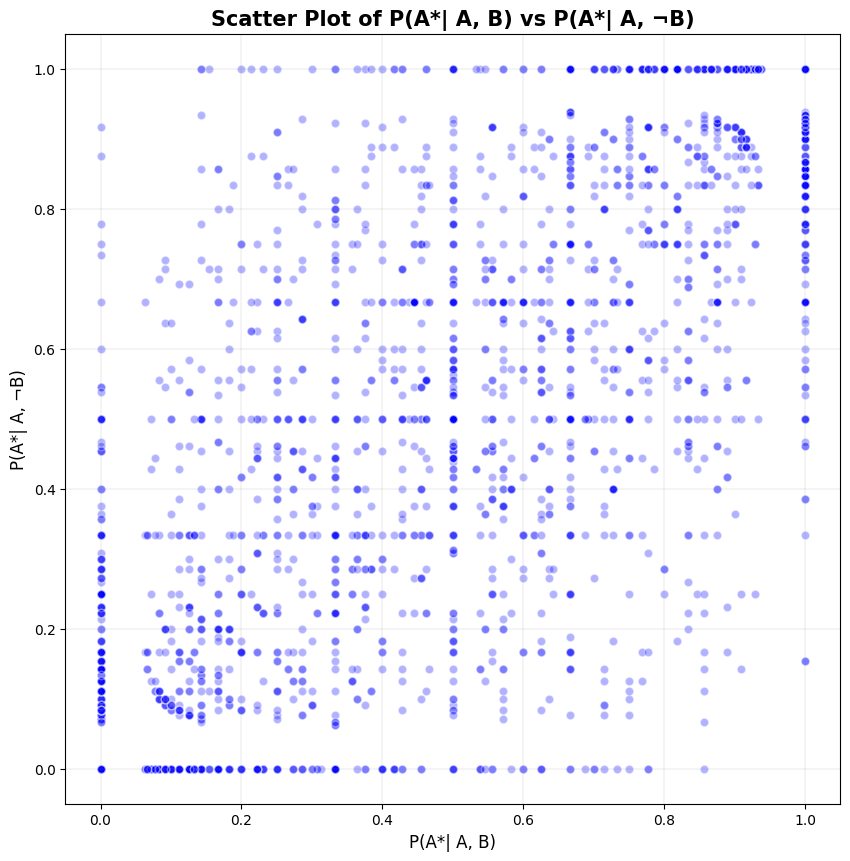

In [11]:
import matplotlib.pyplot as plt

plot_sample = plotting_data.loc[(plotting_data.samples_n > 5) & (plotting_data.samples_a > 5)]

plt.figure(figsize=(10,10)) # Set plot size
plt.scatter(plot_sample.Starts_x_a, plot_sample.Starts_x_n, c='blue', alpha=0.3, edgecolors='w') # Set color, transparency and edge color for dots

plt.title('Scatter Plot of P(A*| A, B) vs P(A*| A, ¬B)', fontweight='bold', fontsize=15) # Add title with font bold and size 15
plt.xlabel('P(A*| A, B)', fontsize=12) # Add x-label with font size 12
plt.ylabel('P(A*| A, ¬B)', fontsize=12) # Add y-label with font size 12

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5) # Add grid lines

plt.show()

In this plot you can see the probabilties of players starting given a teammate is not available (x-axis) and given that teammate starts (y-axis). The point at which x = y, is the point of indifference: it makes no difference whether a teammate is available or not. The top-left corner is the case where an absence of a teammate increases the probability of that player starting. While there is a slight skew to the top-left, there are lots of cases where the data suggests an absence of a teammate seems to decrease a player's probability of starting (bottom right). However, this makes little sense. It is more likely that the data is noisy and likely too unreliable to use alone. It might be worth considering other features such as substitutions (which players tend to interchange and which do not).

To illustrate this skew, lets make a plot showing how many points are in each ninth.

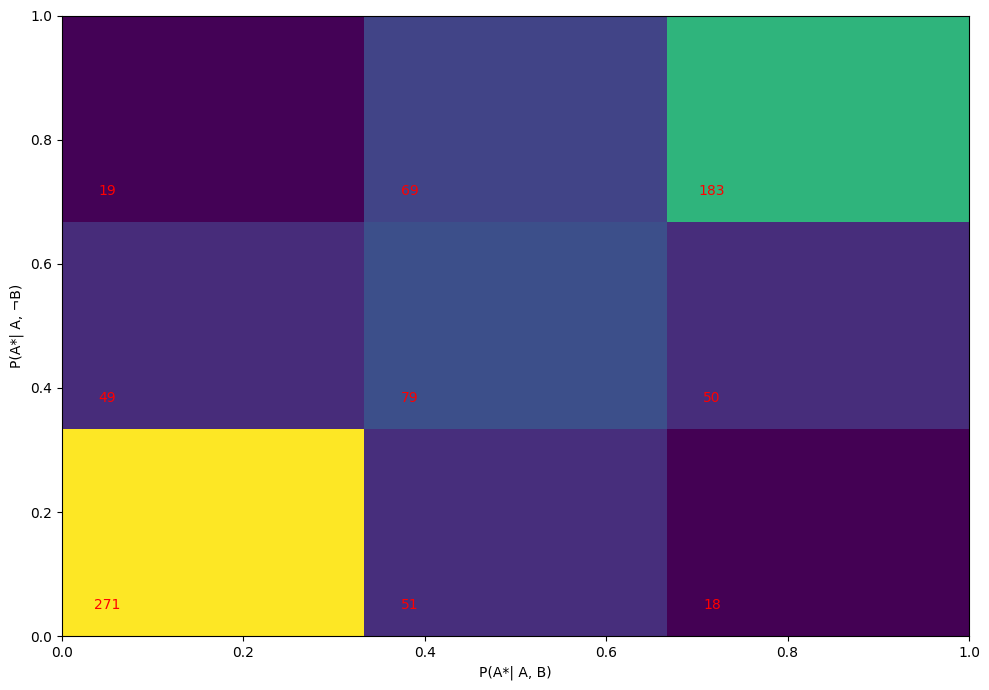

In [31]:
import numpy as np

def plot_symmetry_heatmap(x, y, lower, upper, n, xlabel, ylabel):
    fig, axs = plt.subplots(1, 1,
                            figsize =(10, 7), 
                            tight_layout = True)

    bins = np.linspace(lower, upper, n+1)
    counts, xedges, yedges, im = axs.hist2d(x, y, bins=[bins, bins])

    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            text = axs.text(xedges[i]+0.05, yedges[j]+0.05, int(counts.T[j, i]),
                        ha="center", va="center", color="r")

    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)

    plt.show()

plot_symmetry_heatmap(plot_sample.Starts_x_a, plot_sample.Starts_x_n, 0, 1, 3, "P(A*| A, B)", "P(A*| A, ¬B)")

Because we care about whether probabilities change on teammate availability, can combine the axes into $P(A_*| A, ¬B) - P(A_*| A, B)$, and plot that against $P(B_*| B, ¬A) - P(B_*| B, A)$. Let's see if there is any asymmetry.

In [19]:
A_n = find_probabilities(sample_mesh, None, None, 0, 1, sample_col='Available_y')
plot_sample = plot_sample.join(A_n, lsuffix='', rsuffix='_A').dropna()

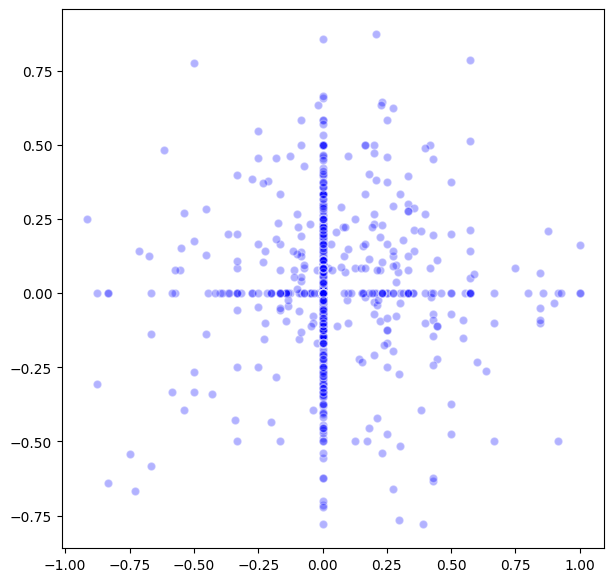

In [22]:

plt.figure(figsize=(7,7)) # Set plot size
x = plot_sample.Starts_y - plot_sample.Starts_y_a
y = plot_sample.Starts_x_n - plot_sample.Starts_x_a
plt.scatter(x, y, c='blue', alpha=0.3, edgecolors='w') # Set color, transparency and edge color for dots

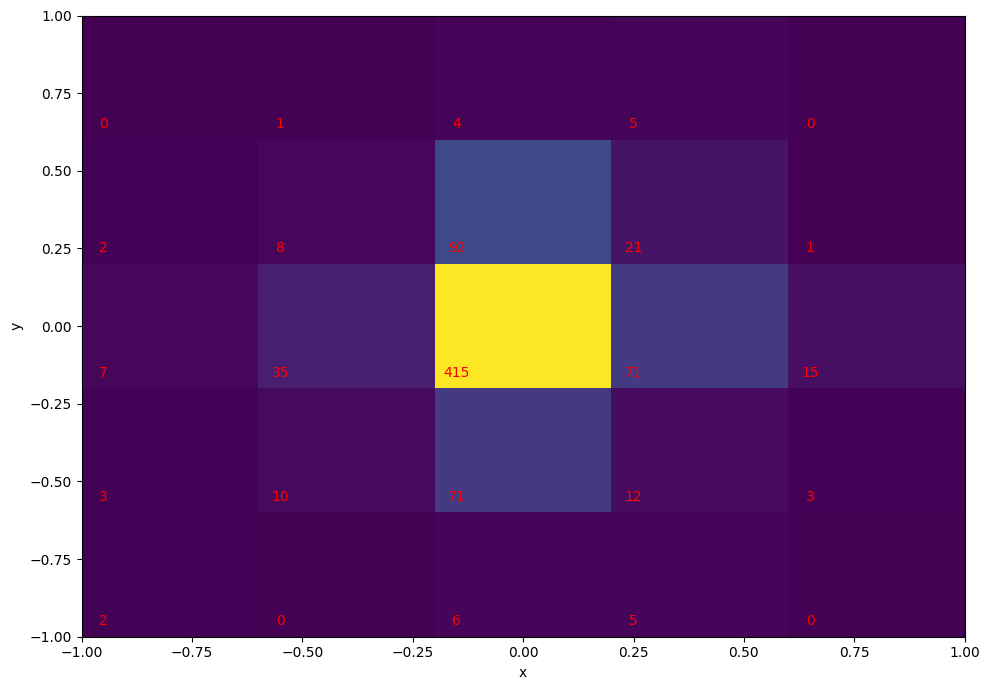

In [39]:
plot_symmetry_heatmap(x, y, -1, 1, 5, "x", "y")

The distribution is only slightly skewed (which would indicate pairs of players where one is the starter and the other is the reserve). Interpreting the data this way does not appear to be useful because it is too noisy.